# Predicting football matches results (data collection and analysis)

In this project, I will build a model that will try to predict outcomes of football matches, i.e. home team win, away team win, or draw. I will use the data about 20 seasons of English Premier League: from 2001/2002 to 2020/2021. My source data will include datasets from Kaggle, as well as data scrapped from other resources.

In [1]:
# importing libraries for data analysis, manipulation, and vizualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
from tqdm.notebook import tqdm
from datetime import datetime

I will start by creating several dataframes that I will use to generate features. These will include:


1. *Matches* dataframe with information about results of all matches starting from season 2001/2002 and starting lineups of home and away teams. The data is taken from [here](https://www.kaggle.com/josephvm/english-premier-league-game-events-and-results).
2. *Final tables* dataframe with information about the final results of each season starting from 2001/2002, including final ranking of teams, numbers of games won, lost, and drawn, and goal difference. The data is taken from [here](https://www.kaggle.com/josephvm/english-premier-league-game-events-and-results).
3. *Players* dataframes with information about key attributes of players of Premier League teams, including related to their attacking, midfield, and defense skills. The attribute ratings are created by FIFA videogames developer and are taken from [here](https://www.kaggle.com/justdhia/fifa-players) and [here](https://www.kaggle.com/cashncarry/fifa-22-complete-player-dataset)

4. *Teams* dataframe with information about ratings of Premier League clubs, also created by FIFA videogames developer. The data is taken from [here](https://www.fifaindex.com/).

5. *Managers* dataframes with information about managers of Premier League clubs and their ratings. The data about managers was scraped from [here](https://en.wikipedia.org/wiki/List_of_Premier_League_managers). The ratings of managers are created by Football World Ranking website owners and were scaped from [here](https://www.clubworldranking.com/ranking-coaches). 

I'll start by importing necessary datasets. Some of them are available from the sources indicated bove, while others were scraped first.

In [2]:
# reading data about matches results, starting from 2001/2002 season
cols = {col: 'object' for col in [136, 141, 143, 145, 146, 148, 149, 151, 152, 154]} 
matches = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/matches.csv', 
                      dtype=cols)
matches.replace({'AFC Bournemouth': 'Bournemouth'}, inplace=True) # correcting the club name

# reading data about the season results, starting from 2001/2002 season
final_tables = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/all_tables.csv')

# reading data about player stats, starting from 2011/2012 season
players_2011 = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/players_2011.csv')
players_2012 = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/players_2012.csv')
players_2013 = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/players_2013.csv')
players_2014 = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/players_2014.csv')
players_2015 = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/players_2015.csv')
players_2016 = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/players_2016.csv')
players_2017 = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/players_2017.csv')
players_2018 = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/players_2018.csv')
players_2019 = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/players_2019.csv')
players_2019.drop(index=8308, inplace=True) # remove unneccesary player with duplicate name
players_2019.replace({'AFC Bournemouth': 'Bournemouth'}, inplace=True) # correcting the name of the club
players_2020 = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/players_2020.csv')

# since I import the dataset with players attributes for 2021/2022 season from another source, I need to rename its columns
rename_attributes_2021 = {
    'Overall': 'Overal',
    'Positioning': 'AttPosition', 
    'HeadingAccuracy': 'Heading',
    'FKAccuracy': 'FKAcc',
    'SlidingTackle': 'SlideTackle',
    'StandingTackle': 'StandTackle',
    'ShortPassing': 'ShortPass',
    'LongPassing': 'LongPass'
}
players_2021 = pd.read_csv('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/players_2021.csv')
players_2021.rename(columns=rename_attributes_2021, inplace=True)

# reading data about teams stats
teams = pd.read_excel('https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/teams.xlsx')
teams.replace({'AFC Bournemouth': 'Bournemouth'}, inplace=True)

In [3]:
# dropping 10 duplicate rows
matches.drop_duplicates(inplace=True)

In [5]:
# scraping data about football managers from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_Premier_League_managers'
html_doc = requests.get(url).text

soup = BeautifulSoup(html_doc, 'html.parser')

In [6]:
# creating managers dataframe
managers_table = soup.find_all('table', class_='wikitable sortable plainrowheaders')[0]
managers_list = pd.read_html(str(managers_table))
managers = pd.DataFrame(managers_list[0])

I will scrape data about rankings of football managers from https://www.clubworldranking.com/. Code is taken and modified from [here](https://github.com/gonzaferreiro/Market_value_football_players/blob/master/Team_and_national_teams_ranking_scraps-Final.ipynb).

In [7]:
# function for extracting managers names
def extract_managers(soup):
    managers = []
    for each in soup.find_all('div', attrs={'class':'col-name'})[1:]:
        try:
            managers.append(each.text.strip())
        except:
            managers.append(np.nan)
    return managers

In [8]:
# function for extracting managers rankings
def extract_rankings(soup):
    rankings = []
    for each in soup.find_all('div', attrs={'class':'points RankingRight'}):
        try:
            rankings.append(int(each.text.strip()))
        except:
            rankings.append(np.nan)
    return rankings

In [9]:
# function to create dataframes with managers rankings
def create_managers_df(week, year):
    results = {'Manager':[], 'Ranking':[]} 
    
    for start in tqdm(range(0, 1000, 25)):
        url = f'https://www.clubworldranking.com/ranking-coaches?wd={week}&yr={year}&index={start}'
        r = requests.get(url)
        soup = BeautifulSoup(r.text,'html.parser')
        results['Manager'] += extract_managers(soup)
        results['Ranking'] += extract_rankings(soup)

    return pd.DataFrame(results)

In [10]:
managers_2011 = create_managers_df(49, 2011)
managers_2012 = create_managers_df(20, 2012)
managers_2013 = create_managers_df(21, 2013)
managers_2014 = create_managers_df(20, 2014)
managers_2015 = create_managers_df(22, 2015)
managers_2016 = create_managers_df(21, 2016)
managers_2017 = create_managers_df(21, 2017)
managers_2018 = create_managers_df(20, 2018)
managers_2019 = create_managers_df(20, 2019)
managers_2020 = create_managers_df(14, 2020)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

After creating the necessary dataframes, I'll proceed to cleaning and fixing errors in them.

I'll start with *matches* dataframe. There is an error in the column indicating years when matches took place. I'll update the year column and then create a separate column with dates of matches in datetime format.

In [11]:
# correcting the mistake in the year column in matches dataframe
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July']
matches['season'] = matches.year

def adjust_year(date, year):
    if any(month in date for month in months):
        return year + 1
    else:
        return year

In [12]:
matches.year = matches.apply(lambda x: adjust_year(x['date'], x['year']), axis=1)

In [13]:
# combining date and year columns into single column
matches.date = matches.date.apply(lambda x: x.split(', ')[1])
matches.year = matches.year.astype('str')
matches.date = matches.date + ', ' + matches.year

# converting date colum in matches to datetime
matches.date = pd.to_datetime(matches.date)

Since I have information about player stats only starting from 2011/2012 season, I need to check whether the *matches* dataframe has data about starting lineups in all matches since 2011. After checking, there is only one match with missing values in starting lineups columns. I will impute the data manually below.

In [14]:
row_5039 = {
    'home_starting_1': 'Joe Hart',
    'home_starting_2': 'Pablo Zabaleta',
    'home_starting_3': 'Vincent Kompany',
    'home_starting_4': 'Martín Demichelis',
    'home_starting_5': 'Gaël Clichy',
    'home_starting_6': 'Fernando',
    'home_starting_7': 'Yaya Touré',
    'home_starting_8': 'James Milner',
    'home_starting_9': 'Jesús Navas',
    'home_starting_10': 'Stevan Jovetić',
    'home_starting_11': 'Sergio Agüero',
    'away_starting_1': 'De Gea',
    'away_starting_2': 'Antonio Valencia',
    'away_starting_3': 'Chris Smalling',
    'away_starting_4': 'Marcos Rojo',
    'away_starting_5': 'Luke Shaw',
    'away_starting_6': 'Daley Blind',
    'away_starting_7': 'Marouane Fellaini',
    'away_starting_8': 'Ángel Di María',
    'away_starting_9': 'Adnan Januzaj',
    'away_starting_10': 'Wayne Rooney',
    'away_starting_11': 'Robin van Persie'
}

for key, value in row_5039.items():
    matches.loc[5039, key] = value

There are suspicious columns named 'home_starting_12', home_starting_13', 'home_starting_14', 'away_starting_12', 'away_starting_13', and 'away_starting_14'. This is impossible as there are only 11 players in the starting lineup. Most likely, players # 12, 13, and 14 were enetered errouneosly and they weren't in the starting squad. Or, these players did play from the start, but in that case, someone from ## 1-11 was entered incorrectly.

I can fix the errors by compaing entries for players ##12, 13, and 14 with the real data from these matches. Then, I will make necessary changes and remove these erroneus columns.

After checking values for players ## 13 and 14 manually, I understand that these values are erroneous, so we can safely drop them. I will turn to dealing with values for players # 12.

In [15]:
cols_to_drop = [col for col in matches.columns if ('starting_13' in col) | ('starting_14' in col)]
matches.drop(columns=cols_to_drop, inplace=True)

In [16]:
# selecting only columns that have information about starting lineups
home_lineup = [col for col in matches.columns if col.startswith('home_starting') & ('num' not in col)]
away_lineup = [col for col in matches.columns if col.startswith('away_starting') & ('num' not in col)]

# creating a list of columns with key information about matches and lineups for simpler data cleaning
cols_to_keep_home = ['home','away', 'date', 'year'] + home_lineup
cols_to_keep_away = ['home','away', 'date', 'year'] + away_lineup

# selecting those matches where there are not null values for 'home_starting_12' column
home_12 = matches[matches.home_starting_12.notna()].copy()

# selecting those matches where there are not null values for 'away_starting_12' column
away_12 = matches[matches.away_starting_12.notna()].copy()

In [17]:
# create a function that takes a list of columns and returns the list of columns that are shifted to the left
def shift_left(columns):
    shifted_columns = []
    for col in columns:
        num = int(col.split('_')[2]) + 1
        shifted_column = col.split('_')[0] + '_' + col.split('_')[1] + '_' + str(num)
        shifted_columns.append(shifted_column)
    return shifted_columns

In [18]:
# shifting the columns for the row #5782, where there is an incorrect entry to the home lineup, to the left
cols_5782 = [
    'home_starting_8', 
    'home_starting_9', 
    'home_starting_10', 
    'home_starting_11'
]
cols_5782_shifted = shift_left(cols_5782)

# shifting the values in the row #5782 to the left
matches.loc[5782, cols_5782] = matches.loc[5782, cols_5782_shifted].values

In [19]:
# shifting the columns for the row #5935, where there is an incorrect entry to the home lineup, to the left
cols_5935 = [
    'home_starting_3', 
    'home_starting_4', 
    'home_starting_5', 
    'home_starting_6', 
    'home_starting_7', 
    'home_starting_8', 
    'home_starting_9', 
    'home_starting_10', 
    'home_starting_11'
]
cols_5935_shifted = shift_left(cols_5935)

# shifting the values in the row #5935 to the left
matches.loc[5935, cols_5935] = matches.loc[5935, cols_5935_shifted].values

In [20]:
# shifting the columns for the other rows, where there are incorrect entries to the home lineup, to the left
cols_home = [
    'home_starting_2', 
    'home_starting_3', 
    'home_starting_4', 
    'home_starting_5', 
    'home_starting_6', 
    'home_starting_7', 
    'home_starting_8', 
    'home_starting_9', 
    'home_starting_10', 
    'home_starting_11'
]
cols_home_shifted = shift_left(cols_home)

# selecting all indices in the away_12 dataframe excpet for the first two
rows_home = home_12.index[2:]

# shifting the values in the other rows to the left
for row in rows_home:
    matches.loc[row, cols_home] = matches.loc[row, cols_home_shifted].values

In [21]:
# shifting the columns for the row #5751, where there is an incorrect entry to the away lineup, to the left
cols_5751 = [
    'away_starting_4', 
    'away_starting_5', 
    'away_starting_6', 
    'away_starting_7', 
    'away_starting_8', 
    'away_starting_9', 
    'away_starting_10', 
    'away_starting_11'
]
cols_5751_shifted = shift_left(cols_5751)

# shifting the values in the row #5751 to the left
matches.loc[5751, cols_5751] = matches.loc[5751, cols_5751_shifted].values

In [22]:
# shifting the columns for the other rows, where there are incorrect entries to the away lineup, to the left
cols_away = [
    'away_starting_2', 
    'away_starting_3', 
    'away_starting_4', 
    'away_starting_5', 
    'away_starting_6', 
    'away_starting_7', 
    'away_starting_8', 
    'away_starting_9', 
    'away_starting_10', 
    'away_starting_11'
]
cols_away_shifted = shift_left(cols_away)

# selecting all indices in the away_12 dataframe excpet for the first
rows_away = away_12.index[1:]

# shifting the values in the other rows to the left
for row in rows_away:
    matches.loc[row, cols_away] = matches.loc[row, cols_away_shifted].values

Done! All incorrect entries in player # 12 columns are fixed.

*Matches* dataframe lacks a tagret column, i.e. the column indicating results of matches I would like to predict. I will add this column to the dataframe by comparing goal by home and away teams in a given match.

In [23]:
# creating the new target column with the results of the matches

condlist = [(matches.home_score > matches.away_score), (matches.home_score == matches.away_score), (matches.home_score < matches.away_score)]
choicelist = ['home_win', 'draw', 'away_win']
matches['result'] = np.select(condlist, choicelist)

Let's have a look at the distribution of wins of home teams, wins of away teams, and draws during the past 11 seasons.

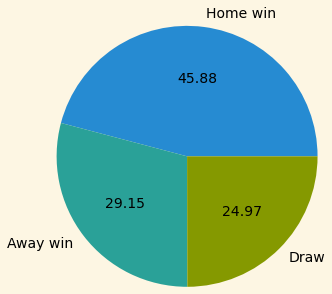

In [24]:
matches_until_2021 = matches[matches.season<2021]
outcomes = ['Home win', 'Away win', 'Draw']
outcome_frequncies = matches_until_2021.result.value_counts().values

plt.style.use('Solarize_Light2')
plt.rcParams.update({'font.size': 14})

plt.pie(outcome_frequncies, labels=outcomes, radius=1.5, autopct='%.2f')
plt.show()

Not surprisingly, the majority of matches during 2001-2020 seasons ended in wins of home teams. The proportions of away wins and draws are comparable with each other.

Next, I will add information about managers of teams. I will map teams to its managers using the data about Premier League team managers from Wikipedia. Later, I will subtitute managers' names with their ratings.

In [25]:
# correcting the dates in managers dataframe
managers.loc[265, 'From'] = '25 November 2004' 
managers.loc[39, 'From'] = '7 September 2004' 
managers.loc[203, 'From'] = '12 March 2004' 

In [26]:
# converting the dates in managers dataframe to datetime
today = datetime.today().strftime('%Y-%m-%d') # setting the current date
managers.From = managers.From.str.rstrip('\[[abcdefgh]\]')
managers.Until = managers.Until.str.rstrip('\[[abcdefgh]\]')
managers.Until = managers.Until.str.replace('Present\*', today)

managers.From = pd.to_datetime(managers.From)
managers.Until = pd.to_datetime(managers.Until)

C:\Users\Oleksii\AppData\Local\Temp/ipykernel_1428/3079215716.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  managers.Until = managers.Until.str.replace('Present\*', today)


In [27]:
# creating dictionary that maps club to their managers
clubs_managers = {}

for index, row in managers.iterrows():
    
    club = row[2]
    manager = row[0]
    start = row[3]
    end = row[4]
    
    if club not in clubs_managers: 
        clubs_managers[club] = []
    
    clubs_managers[club].append((manager, start, end))

In [28]:
# creating a funntion that selects managers of a club based on date a match was played

def select_manager(club, date):
    for manager in clubs_managers[club]:
        if manager[1] <= date <= manager[2]:
            return manager[0]

In [29]:
# applying the function to create home_manager and away_manager columns
matches['home_manager'] = matches.apply(lambda x: select_manager(x['home'], x['date']), axis=1)
matches['away_manager'] = matches.apply(lambda x: select_manager(x['away'], x['date']), axis=1)

matches.loc[4473, 'away_manager'] = 'Eamonn Dolan' # imputing missing value

After cleaning and updating the main *matches* dataframe, I will proceed to creating features that will be used for predictions. I will create two types of features:
*   features that relate specifically to home team and away team;
*   difference between feature values of home team and away team.

**First feature** will be based on outcomes of previous matches between home and away teams. I will calculate differences between home and away team wins and between goals scored by home and away teams in previous matches.

In [30]:
# function for getting past results between the teams
def past_results(home_team, away_team, year):
    
    past_matches = matches[(matches.home==home_team) & (matches.away==away_team) & (matches.season<year)]
    past_results = past_matches['result'].value_counts()

    if 'home_win' in past_results: 
        past_home_wins = past_results['home_win']
    else:
        past_home_wins = 0

    if 'away_win' in past_results: 
        past_away_wins = past_results['away_win']
    else:
        past_away_wins = 0

    diff_past_results = past_home_wins - past_away_wins

    home_team_score = past_matches['home_score'].sum()
    away_team_score = past_matches['away_score'].sum()
    diff_score = home_team_score - away_team_score
    
    return diff_past_results, diff_score

In [31]:
matches['diff_past_results'] = matches.apply(lambda x: past_results(x['home'], x['away'], x['season'])[0], axis=1)
matches['diff_past_goals'] = matches.apply(lambda x: past_results(x['home'], x['away'], x['season'])[1], axis=1)

For my next features, I'll need to map players' names to their ratings in the corresponding year. But first, I need to fix errors and discrepancies in *players* dataframes.

To start, I'll divide *matches* dataframe into 11 separate dataframes acording to differet seasons. I will select only those columns from the matches dataframe that are relevant to our feature engeneering pursposes.

I'll then use these dataframes to insert data about ratings of teams, players, and managers for a given season.

In [32]:
# selecting only those columns that are relevant for our task
add_cols = [
    'home_manager', 
    'away_manager', 
    'diff_past_results', 
    'diff_past_goals', 
    'result',
]

cols_to_keep = ['home', 'away'] + home_lineup[:-1] + away_lineup[:-1] + add_cols

# creating yearly matches dataframe with relevant columns
matches_2011 = matches[matches.season == 2011][cols_to_keep]
matches_2012 = matches[matches.season == 2012][cols_to_keep]
matches_2013 = matches[matches.season == 2013][cols_to_keep]
matches_2014 = matches[matches.season == 2014][cols_to_keep]
matches_2015 = matches[matches.season == 2015][cols_to_keep]
matches_2016 = matches[matches.season == 2016][cols_to_keep]
matches_2017 = matches[matches.season == 2017][cols_to_keep]
matches_2018 = matches[matches.season == 2018][cols_to_keep]
matches_2019 = matches[matches.season == 2019][cols_to_keep]
matches_2020 = matches[matches.season == 2020][cols_to_keep]
matches_2021 = matches[matches.season == 2021][cols_to_keep]

In [33]:
# creating a function that adds missing players to players dataframe
def append_players(players_scores, players_df):
    additional_players = pd.DataFrame(players_scores)
    players_df = players_df.append(additional_players, ignore_index=True)
    return players_df

In [34]:
additional_players_2011 = {
  'Name': ['Bruno Perone', 'Jake Kean', 'Mahamadou Diarra', 'Nicolas Anelka', 'Patrick Agyemang'],
  'Overal': [63, 59, 78, 83, 61],
  'Potential': [71, 72, 82, 85, 64],
}

additional_players_2012 = {
  'Name': ['Anton Ferdinand', 'Djibril Cissé', 'Jamie Carragher', 'Karim Rekik', 'Kaspars Gorkss', 'Kieron Courtney Dyer', 'Paul Scharner', 'Paul Scholes', 'Phil Neville', 'Ryan Nelsen'],
  'Overal': [71, 79, 76, 68, 68, 69, 75, 81, 74, 74],
  'Potential': [72, 79, 76, 80, 70, 69, 75, 81, 74, 74],
}

additional_players_2013 = {
  'Name': ['Craig Bellamy', 'Muamer Tankovic', 'Nicolas Anelka', 'Ryan Giggs'],
  'Overal': [75, 65, 80, 80],
  'Potential': [75, 75, 80, 80],
}

additional_players_2014 = {
  'Name': ['Hatem Ben Arfa', 'Oussama Assaidi', 'Rio Ferdinand', 'Steven Reid'],
  'Overal': [81, 74, 79, 69],
  'Potential': [81, 75, 79, 69],
}

additional_players_2015 = {
  'Name': ['Adam Johnson', 'Brede Hangeland', 'Kelvin Davis', 'Matt Grimes', 'Pedro Chirivella', 'Ramires', 'Nikica Jelavić'],
  'Overal': [78, 72, 71, 62, 61, 81, 73],
  'Potential': [78, 72, 71, 74, 70, 81, 73],
}

additional_players_2016 = {
  'Name': ['Joey Barton', 'Odion Ighalo', 'Álvaro Arbeloa', 'Gastón Ramirez', 'Allan-Roméo Nyom'],
  'Overal': [74, 77, 74, 78, 78],
  'Potential': [74, 78, 74, 81, 78],
}

additional_players_2017 = {
  'Name': ['Leon Britton', 'Liam Rosenio', 'Michael Carrick', 'Per Mertesacker', 'Liam Rosenior'],
  'Overal': [75, 70, 79, 80, 70],
  'Potential': [75, 70, 79, 80, 70],
}

additional_players_2018 = {
  'Name': ['Ben Johnson', 'Daniel Sturridge', 'Petr Čech'],
  'Overal': [58, 78, 81],
  'Potential': [75, 78, 81],
}

additional_players_2019 = {
  'Name': ['Leighton Baines'],
  'Overal': [75],
  'Potential': [75],
}

additional_players_2020 = {
  'Name': ['Alexandre Jankewitz', 'Amad Diallo', 'Anthony Elanga', 'Daniel Jebbison'],
  'Overal': [60, 66, 63, 59],
  'Potential': [77, 86, 80, 75],
}

additional_players_2021 = {
  'FullName': [
           'Adam Webster', 
           'Ashley Barnes', 
           'Benjamin Mendy', 
           'Christian Benteke', 
           'Federico Fernández', 
           'Gabriel', 
           'Hwang Hee-Chan', 
           'Jeff Schlupp', 
           'Joshua King', 
           'Kristoffer Ajer', 
           'Liam Cooper',
           'Marvelous Nakamba',
           'Nicolas Nkoulou',
           'Solly March',
           'Stuart Dallas',
           'Tyler Morton',
           'Wilfredo Caballero'
           ],
  'Overal': [76, 75, 79, 75, 75, 83, 75, 75, 75, 75, 75, 75, 78, 75, 75, 59, 74],
  'Potential': [80, 75, 80, 75, 75, 87, 78, 75, 75, 83, 75, 77, 78, 76, 75, 77, 74],
}

In [35]:
players_2011 = append_players(additional_players_2011, players_2011)
players_2012 = append_players(additional_players_2012, players_2012)
players_2013 = append_players(additional_players_2013, players_2013)
players_2014 = append_players(additional_players_2014, players_2014)
players_2015 = append_players(additional_players_2015, players_2015)
players_2016 = append_players(additional_players_2016, players_2016)
players_2017 = append_players(additional_players_2017, players_2017)
players_2018 = append_players(additional_players_2018, players_2018)
players_2019 = append_players(additional_players_2019, players_2019)
players_2020 = append_players(additional_players_2020, players_2020)
players_2021 = append_players(additional_players_2021, players_2021)

In [36]:
# creating pairs of players whose names differ between matches and players datasets

players_dict = {
    'Albert Crusat': 'Crusat',
    'Andrea Orlandi': 'Orlandi',
    'Andrey Arshavin': 'Andrei Arshavin',
    'David Ngog': "David N'Gog",
    'Fabio Aurelio': 'Fábio Aurélio',
    'Gael Givet': 'Gaël Givet',
    'Gonzalo Jara': 'Gonzalo Jara Reyes',
    'Gretar Rafn Steinsson': 'Grétar Steinsson',
    'Haris Vuckic': 'Haris Vučkić',
    'Henrique Hilario': 'Hilário',
    'Ivan Klasnic': 'Ivan Klasnić',
    'Luka Modric': 'Luka Modrić',
    'Markus Olsson': 'Marcus Olsson',
    'Marton Fulop': 'Márton Fülöp',
    'Maxi Rodríguez': 'Maximiliano Rodríguez',
    'Míchel Salgado': 'Michel Salgado',
    'Nenad Milijas': 'Nenad Milijaš',
    'Patrick Kenny': 'Paddy Kenny',
    'Peter Lövenkrands': 'Peter Løvenkrands',
    'Radek Cerny': 'Radek Černý',
    'Radosav Petrovic': 'Radosav Petrović',
    'Robert Hulse': 'Rob Hulse',
    'Rubén Rochina': 'Rochina',
    'Sam Rickett': 'Sam Ricketts',
    'Simon Vukcevic': 'Simon Vukčević',
    'Tuncay Sanli': 'Tuncay',
    'Vedran Corluka': 'Vedran Ćorluka',
    'Yakubu Aiyegbeni': 'Yakubu',
    'Zdenek Grygera': 'Zdeněk Grygera',
    'Adam Le Fondre': 'Adam le Fondre',
    'Adrián Rodriguez': 'Adrián López',
    'Ali Al Habsi': 'Ali Al-Habsi',
    'Carlos Tevez': 'Carlos Tévez',
    'Esteban Granero': 'Granero',
    'Etey Shechter': 'Itay Shechter',
    'Franco Di Santo': 'Franco di Santo',
    'Gabriel Tamas': 'Gabriel Tamaş',
    'Gaël Bigirimana': 'Gael Bigirimana',
    'Jan Mucha': 'Ján Mucha',
    'Marc-Antoine Fortune': 'Marc-Antoine Fortuné',
    'Mladen Petric': 'Mladen Petrić',
    'Nuri Sahin': 'Nuri Şahin', 
    'Park Ji-Sung': 'Ji Sung Park',
    'Rafael Van der Vaart': 'Rafael van der Vaart',
    'Raul Meireles': 'Raúl Meireles',
    'Roman Golobart': 'Román Golobart',
    "Stéphane M'bia": 'Stéphane MBia',
    'Alex Kacaniklic': 'Alexander Kačaniklić',
    'Antonio Luna': 'Luna',
    'Bryan Ruiz': 'Bryan Ruíz',
    'Cala': 'Juan Cala',
    'Carlos Jimenez Cuellar': 'Carlos Cuéllar',
    'Charalampos Mavrias': 'Charis Mavrias',
    'Daniel Gabbidon': 'Danny Gabbidon',
    'Elsad Zverotic': 'Elsad Zverotić',
    'Fabio': 'Fabio Borini',
    'Georgios Karagounis': 'Giorgios Karagounis',
    'Javier Garrido': 'Garrido',
    'Ji Dong-Won': 'Dong Won Ji',
    'Jimmy Kebe': 'Jimmy Kébé',
    'Jonathan de Guzmán': 'Jonathan De Guzmán',
    'José Campaña': 'Campaña',
    'Jussi Jaaskelainen': 'Jussi Jääskeläinen',
    'Kieren Westwood': 'Keiren Westwood',
    'Kim Bo-Kyung': 'Bo Kyung Kim',
    'Kostas Mitroglou': 'Konstantinos Mitroglou',
    'Mapou Yanga-Mbiwa': "Mapou Yanga-M'Biwa",
    'Matija Nastasic': 'Matija Nastasić',
    'Mats Daehli': 'Mats Møller Dæhli',
    'Michael Essien': 'Michaël Essien',
    'Mobido Diakité': 'Modibo Diakité',
    'Modibo Maíga': 'Modibo Maïga',
    'Nemanja Vidic': 'Nemanja Vidić',
    'Ondrej Celustka': 'Ondřej Čelůstka',
    'Pablo Osvaldo': 'Pablo Daniel Osvaldo',
    'Razvan Rat': 'Răzvan Raţ',
    'Thomas Sorensen': 'Thomas Sørensen',
    'Tomas Kalas': 'Tomáš Kalas',
    'Zoltan Gera': 'Zoltán Gera',
    'Álex Pozuelo': 'Pozuelo',
    'Álvaro Vázquez':'Álvaro',
    'Alejandro Faurlin': 'Alejandro Faurlín',
    'Alex Song':	'Alexandre Song',
    'Andrej Kramaric':	'Andrej Kramarić',
    'Andy Robertson': 'Andrew Robertson',
    'Angel Rangel': 'Àngel Rangel',
    'Anthony Reveillere': 'Anthony Réveillère',
    'Antolin Alcaraz': 'Antolín Alcaraz',
    'Armand Traore': 'Armand Traoré',
    'Asmir Begovic': 'Asmir Begović',
    'Ayoze Perez': 'Ayoze Pérez',
    'Bafetimbi Gomis': 'Bafétimbi Gomis',
    'Bojan Krkic': 'Bojan',
    'Branislav Ivanovic': 'Branislav Ivanović',
    'César Azpilicueta': 'Azpilicueta',
    'David de Gea': 'De Gea',
    'Dusan Tadic': 'Dušan Tadić',
    'Edin Dzeko': 'Edin Džeko',
    'Eldin Jakupovic': 'Eldin Jakupović',
    'Emiliano Martínez': 'Emiliano Martinez',
    'Filip Djuricic': 'Filip Đuričić',
    'Florin Gardos': 'Florin Gardoş',
    'Gastón Ramírez': 'Gastón Ramirez',
    'Gylfi Sigurdsson': 'Gylfi Sigurðsson',
    'Javier Manquillo': 'Manquillo',
    'Jazz Richards': 'Ashley Richards',
    'Jeff Schlupp': 'Jeffrey Schlupp',
    'José Pozo': 'Pozo',
    'Julian Speroni': 'Julián Speroni',
    'Ki Sung-Yueng': 'Ki Sung Yueng',
    'Lazar Markovic': 'Lazar Marković',
    'Lee Chung-Yong': 'Lee Chung Yong',
    'Lukasz Fabianski': 'Łukasz Fabiański',
    'Mame Biram Diouf': 'Mame Diouf',
    'Marko Arnautovic': 'Marko Arnautović',
    'Martin Skrtel': 'Martin Škrtel',
    'Massadio Haidara': 'Massadio Haïdara',
    'Matthew Jarvis': 'Matt Jarvis',
    'Matthew Taylor': 'Matt Taylor',
    'Michael Williamson': 'Mike Williamson',
    'Mike Duff': 'Michael Duff',
    'Mile Jedinak': 'Mile Jedinák',
    'Mousa Dembélé': 'Moussa Dembélé',
    'Muhamed Besic': 'Muhamed Bešić',
    'Nemanja Matic': 'Nemanja Matić',
    'Nikica Jelavic': 'Nikica Jelavić',
    'Niko Kranjcar': 'Niko Kranjčar',
    'Papiss Cissé': 'Papiss Demba Cissé',
    'Petr Cech': 'Petr Čech',
    'Philippe Coutinho': 'Coutinho',
    'Radamel Falcao': 'Falcao',
    'Ricardo Alvarez': 'Ricardo Álvarez',
    'Ricardo Vaz Te': 'Ricardo Vaz Tê',
    'Ritchie de Laet': 'Ritchie De Laet',
    'Robert Elliot': 'Rob Elliot',
    'Robert Green': 'Rob Green',
    'Roberto Soldado': 'Soldado',
    'Seamus Coleman': 'Séamus Coleman',
    'Silvestre Varela': 'Varela',
    'Stevan Jovetic': 'Stevan Jovetić',
    'Stéphane Sessegnon': 'Stéphane Sessègnon',
    'Thomas Carroll': 'Tom Carroll',
    'Tom Ince': 'Thomas Ince',
    'Tomas Rosicky': 'Tomáš Rosický',
    'Vlad Chiriches': 'Vlad Chiricheş',
    'Víctor Valdés': 'Victor Valdés',
    'Wilfredo Caballero': 'Willy Caballero',
    'William Buckley': 'Will Buckley',
    'Wojciech Szczesny': 'Wojciech Szczęsny',
    'Younes Kaboul': 'Younès Kaboul',
    'Yun Suk-Young': 'Yun Suk Young',
    'Étienne Capoue': 'Etienne Capoue',
    'Adam Bogdan': 'Ádám Bogdán',
    'Aleksandar Mitrovic': 'Aleksandar Mitrović',
    'Allan Nyom': 'Allan-Roméo Nyom',
    'Baba Rahman': 'Abdul Rahman Baba',
    'Cédric Soares': 'Cédric',
    'Gerard Deulofeu': 'Deulofeu',
    'Gullermo Varela': 'Guillermo Varela',
    'Heurelho Gomes': 'Gomes',
    'Jonathan Howson': 'Jonny Howson',
    'José Holebas': 'Jose Holebas',
    'José Manuel Jurado': 'Jurado',
    'Miguel Britos': 'Miguel Angel Britos',
    'Sebastien Bassong': 'Sébastien Bassong',
    'Son Heung-Min': 'Heung Min Son',
    "Yann M'vila": "Yann M'Vila",
    'José Ángel Crespo': 'Crespo',
    'Adama Diomandé': 'Adama Valentin Diomande',
    'Antonio Barragán': 'Barragán',
    'Cristhian Stuani': 'Christian Stuani',
    "Didier N'Dong": 'Didier Ndong',
    'Emilio Nsue': 'Nsue',
    'Evandro Goebel': 'Evandro',
    'Fernando Llorente': 'Llorente',
    'Ilkay Gündogan': 'İlkay Gündoğan',
    'Johann Gudmundsson': 'Jóhann Berg Gudmundsson',
    'Josh Harrop': 'Joshua Harrop',
    'Joël Matip': 'Joel Matip',
    'Juan Zúñiga': 'Juan Camilo Zúñiga',
    'Luis Hernández': 'Luís Hernández',
    'Luka Milivojevic': 'Luka Milivojević',
    'Wilfred Ndidi': 'Onyinye Ndidi',
    'Zlatan Ibrahimovic': 'Zlatan Ibrahimović',
    'Álvaro Negredo': 'Negredo',
    'Aleksandar Dragovic': 'Aleksandar Dragović',
    "Badou N'Diaye": 'Badou Ndiaye',
    'Biram Kiyal': 'Beram Kayal',
    'Daniel Williams': 'Danny Williams',
    'Davy Propper': 'Davy Pröpper',
    'Fousseyni Diabate': 'Fousseni Diabaté',
    'Jairo Riedewald': 'Jaïro Riedewald',
    'Jeremie Boga': 'Jérémie Boga',
    'Lasse Sorenson': 'Lasse Sörensen',
    'Lucas Moura': 'Lucas',
    'Martin Dubravka': 'Martin Dúbravka',
    'Mat Ryan': 'Mathew Ryan',
    'Mikel Merino': 'Merino',
    'Nikola Vlasic': 'Nikola Vlašić',
    'Olexandr Zinchenko': 'Oleksandr Zinchenko',
    'Pascal Gross': 'Pascal Groß',
    'Phillip Biling': 'Philip Billing',
    'Sandro Ramírez': 'Sandro',
    'Sead Kolasinac': 'Sead Kolašinac',
    'Thomas Edwards': 'Tom Edwards',
    'Tiemoué Bakayoko': 'Tiémoué Bakayoko',
    'Vicente Iborra': 'Iborra',
    'Álvaro Morata': 'Morata',
    'André-Frank Zambo Anguissa': 'André-Franck Zambo Anguissa',
    'Bobby De Cordova-Reid': 'Bobby Reid',
    'Daniel Ward': 'Danny Ward',
    'Fabri': 'Fabricio',
    'Jon Gorenc Stankovic': 'Jon Gorenc Stanković',
    'Karlan Ahearne-Grant': 'Karlan Grant',
    'Kepa Arrizabalaga': 'Kepa',
    'Martín Montoya': 'Montoya',
    'Matej Vydra': 'Matěj Vydra',
    'Mateo Kovacic': 'Mateo Kovačić',
    'Matteo Guendouzi': 'Mattéo Guendouzi',
    'Mohammed Elyounoussi': 'Mohamed Elyounoussi',
    'Naby Keita': 'Naby Keïta',
    'Ruben Vinagre': 'Rúben Vinagre',
    'Sokratis Papastathopoulos': 'Sokratis',
    'Sol Bamba': 'Souleymane Bamba',
    'Vicente Guaita': 'Guaita',
    'Víctor Camarasa': 'Camarasa',
    'Yann Valery': 'Yan Valery',
    'Yoshinori Muto': 'Yoshinori Mutō',
    'Çaglar Söyüncü': 'Çağlar Söyüncü',
    'Arnaut Danjuma': 'Arnaut Danjuma Groeneveld',
    'Christoph Zimmerman': 'Christoph Zimmermann',
    'Edward Nketiah': 'Eddie Nketiah',
    'Jesús Vallejo': 'Vallejo',
    'Josip Drmic': 'Josip Drmić',
    'Mario Vrancic': 'Mario Vrančić',
    'Mbwana Samatta': 'Mbwana Ally Samatta',
    'Tomas Soucek': 'Tomáš Souček',
    'Trézéguet': 'Trezeguet',
    'William Smallbone': 'Will Smallbone',
    'Carlos Vinicius': 'Vinícius',
    'Douglas Carioca': 'Douglas Luiz',
    'Fernando Marçal':  'Marçal',
    'Ferrán Torres': 'Ferran Torres',
    'Filip Krovinovic': 'Filip Krovinović',
    'Marek Rodak': 'Marek Rodák',
    'Matthew Cash': 'Matty Cash',
    'Okay Yokuslu': 'Okay Yokuşlu',
    'Rayan Aït-Nouri': 'Rayan Aït Nouri',
    'Sergio Reguilón': 'Reguilón',
    'Vladimir Coufal':	 'Vladimír Coufal'
 }

players_2011_dict = players_dict.copy()
players_2012_dict = players_dict.copy()
players_2013_dict = players_dict.copy()
players_2017_dict = players_dict.copy()
players_2018_2019_dict = players_dict.copy()
players_2020_dict = players_dict.copy()

keys_to_remove_2011 = ['Alex Kacaniklic', 'Jonathan Howson', 'Asmir Begovic']

for key in keys_to_remove_2011:
    players_2011_dict.pop(key)

players_2011_dict.update({
    'Wes Hoolahan': 'Wesley Hoolahan',
    'Alex Kacaniklic': 'Alexander Kacaniklic',
    'Benoît Assou-Ekotto': 'Benoit Assou-Ekotto',
    'Juan Mata': 'Mata',
    'Kieron Courtney Dyer': 'Kieron Dyer',
    'Ahmed Elmohamady': 'Ahmed El Mohamady',
    'Jon Flanagan': 'John Flanagan'
})

keys_to_remove_2012 = ['Alex Kacaniklic', 'Jonathan Howson', 'Robert Green', 'Asmir Begovic', 'Ki Sung-Yueng']

for key in keys_to_remove_2012:
    players_2012_dict.pop(key)

players_2012_dict.update({
    'Alex Kacaniklic': 'Alexander Kacaniklic',
    'Ki Sung-Yueng': 'Sung-Yueng Ki',
    'Wes Hoolahan': 'Wesley Hoolahan',
    'Nacho Monreal': 'Monreal',
    'Joel Robles': 'Joel',
    'Nathan Aké': 'Nathan Ake',
    'Pepe Reina': 'José Reina'
})

keys_to_remove_2013 = ['Jonathan Howson', 'Matthew Jarvis', 'Ki Sung-Yueng']

for key in keys_to_remove_2013:
    players_2013_dict.pop(key)

players_2013_dict['Ki Sung-Yueng'] = 'Sung-Yueng Ki'

keys_to_remove_2017 = ['Johann Gudmundsson', 'Allan Nyom', 'Tom Ince']

for key in keys_to_remove_2017:
    players_2017_dict.pop(key)

keys_to_remove_2018_2019 = keys_to_remove_2017 + ['Wilfred Ndidi', 'Miguel Britos', 'Emiliano Martínez']

for key in keys_to_remove_2018_2019:
    players_2018_2019_dict.pop(key)

keys_to_remove_2020 = ['Johann Gudmundsson', 'Tom Ince', 'Wilfred Ndidi', 'Emiliano Martínez', 'Bobby De Cordova-Reid']

for key in keys_to_remove_2020:
    players_2020_dict.pop(key)

for dictionary in [players_2017_dict, players_2018_2019_dict, players_2020_dict]:
    dictionary['Johann Gudmundsson'] = 'Jóhann Berg Guðmundsson'

players_2020_dict.update({'Vitinha': 'Vítor Ferreira', 'Bobby De Cordova-Reid': 'Bobby Decordova-Reid'})

players_2021_dict = {
    'Alex Telles': 'Alex Nicolao Telles',
    'Alisson': 'Alisson Ramses Becker',
    'Allan': 'Allan Marques Loureiro',
    'André Gomes': 'André Filipe Tavares Gomes',
    'Andy Robertson': 'Andrew Robertson',
    'Asmir Begovic': 'Asmir Begović',
    'Ayoze Perez': 'Ayoze Pérez Gutiérrez',
    'Ayoze Pérez': 'Ayoze Pérez Gutiérrez',
    'Bernardo Silva': 'Bernardo Mota Carvalho e Silva',
    'Boubakary Soumare': 'Boubakary Soumaré',
    'Bruno Fernandes': 'Bruno Miguel Borges Fernandes',
    'Caglar Söyüncü': 'Çağlar Söyüncü',
    'Charles Goode': 'Charlie Goode',
    'Christian Norgaard': 'Christian Nørgaard',
    'Cristiano Ronaldo': 'C. Ronaldo dos Santos Aveiro',
    'Cucho Hernández': 'Juan Camilo Hernández',
    'Cédric Soares': 'Cédric Ricardo Alves Soares',
    'César Azpilicueta': 'César Azpilicueta Tanco',
    'Daniel Podence': 'Daniel Castelo Podence',
    'David Raya': 'David Raya Martin',
    'David de Gea': 'David De Gea Quintana',
    'Diego Llorente': 'Diego Javier Llorente Ríos',
    'Diogo Dalot': 'José Diogo Dalot Teixeira',
    'Diogo Jota': 'Diogo José Teixeira da Silva',
    'Douglas Luiz': 'Douglas Luiz Soares de Paulo',
    'Ederson': 'Ederson Santana de Moraes',
    'Emerson': 'Emerson Leite De Souza',
    'Fabinho': 'Fábio Henrique Tavares',
    'Fernandinho': 'Fernando Luiz Rosa',
    'Fernando Marçal': 'Fernando Marçal de Oliveira',
    'Ferran Torres': 'Ferran Torres García',
    'Francisco Trincão': 'Francisco Mota Castro Trincão',
    'Fred': 'Frederico de Paula Santos',
    'Gabriel Jesus': 'Gabriel Fernando de Jesus',
    'Gabriel Martinelli': 'Gabriel Teodoro Martinelli Silva',
    'Ilkay Gündogan': 'İlkay Gündoğan',
    'Jacob Lungi Sorensen': 'Jacob Sørensen',
    'Jairo Riedewald': 'Jaïro Riedewald',
    'Javier Manquillo': 'Javier Manquillo Gaitán',
    'Joelinton': 'Joelinton Apolinário de Lira',
    'Johann Gudmundsson': 'Jóhann Berg Guðmundsson',
    'Jorginho': 'Luiz Frello Filho Jorge',
    'Joshua Sargent': 'Josh Sargent',
    'José Sá': 'José Pedro Malheiro de Sá',
    'João Cancelo': 'João Pedro Cavaco Cancelo',
    'João Moutinho': 'João Filipe Moutinho',
    'João Pedro': 'João Pedro Junqueira de Jesus',
    'Joël Matip': 'Joel Matip',
    'Juan Hernández': 'Juan Camilo Hernández',
    'Júnior Firpo': 'Héctor Junior Firpo Adamés',
    'Kieran Dewsbury-Hall': 'Kiernan Dewsbury-Hall',
    'Kiko Femenía': 'Francisco Femenía Far',
    'Lucas Moura': 'Lucas Rodrigues M. Silva',
    'Luka Milivojevic': 'Luka Milivojević',
    'Lukasz Fabianski': 'Łukasz Fabiański',
    'Lyanco': 'Lyanco Neves Vojnovic',
    'Mads Bech Sörensen': 'Mads Bech Sørensen',
    'Marc Cucurella': 'Marc Cucurella Saseta',
    'Marc Guehi': 'Marc Guéhi',
    'Marcos Alonso': 'Marcos Alonso Mendoza',
    'Matej Vydra': 'Matěj Vydra',
    'Mateo Kovacic': 'Mateo Kovačić',
    'Mathias Jorgensen': 'Mathias Jørgensen',
    'Matthew Cash': 'Matty Cash',
    'Mohammed Elyounoussi': 'Mohamed Elyounoussi',
    'Naby Keita': 'Naby Keïta',
    'Nemanja Matic': 'Nemanja Matić',
    'Nikola Vlasic': 'Nikola Vlašić',
    'Nuno Tavares': 'Nuno Albertino Varela Tavares',
    'Nélson Semedo': 'Nélson Cabral Semedo',
    'Odsonne Édouard': 'Odsonne Edouard',
    'Oriol Romeu': 'Oriol Romeu Vidal',
    'Pablo Fornals': 'Pablo Fornals Malla',
    'Pablo Marí': 'Pablo Marí Villar',
    'Pascal Gross': 'Pascal Groß',
    'Peter Etebo': 'Oghenekaro Etebo',
    'Pierre-Emile Hojbjerg': 'Pierre-Emile Højbjerg',
    'Przemyslaw Placheta': 'Przemysław Płacheta',
    'Raphinha': 'Raphael Dias Belloli',
    'Rayan Aït-Nouri': 'Rayan Aït Nouri',
    'Ricardo Pereira': 'Ricardo Barbosa Pereira',
    'Richarlison': 'Richarlison de Andrade',
    'Robert Sánchez': 'Robert Lynch Sanchéz',
    'Roberto Firmino': 'Roberto Firmino Barbosa de Oliveira',
    'Rodri': 'Rodrigo Hernández Cascante',
    'Rodrigo': 'Rodrigo Moreno Machado',
    'Rúben Dias': 'Rúben Santos Gato Alves Dias',
    'Rúben Neves': 'Rúben Diogo da Silva Neves',
    'Saúl Ñíguez': 'Saúl Ñíguez Esclápez',
    'Sead Kolasinac': 'Sead Kolašinac',
    'Seamus Coleman': 'Séamus Coleman',
    'Sergi Canós': 'Sergi Canós Tenés',
    'Sergio Reguilón': 'Sergio Reguilón Rodríguez',
    'Son Heung-Min': 'Heung Min Son',
    'Thiago Alcántara': 'Thiago Alcântara',
    'Thiago Silva': 'Thiago Emiliano da Silva',
    'Tomás Soucek': 'Tomáš Souček',
    'Trevor Chalobah': 'Trevoh Chalobah',
    'Valentino Livramento': 'Tino Livramento',
    'Vicente Guaita': 'Vicente Guaita Panadero',
    'William Smallbone': 'Will Smallbone',
    'Álvaro Fernández': 'Álvaro Fernández Llorente'
}

In [37]:
#correcting the names of players

matches_2011.replace(players_2011_dict, inplace=True)

matches_2012.replace(players_2012_dict, inplace=True)

matches_2013.replace(players_2013_dict, inplace=True)

for df in [matches_2014, matches_2015, matches_2016]:
    df.replace(players_dict, inplace=True)

matches_2017.replace(players_2017_dict, inplace=True)

for df in [matches_2018, matches_2019]:
    df.replace(players_2018_2019_dict, inplace=True)

matches_2020.replace(players_2020_dict, inplace=True)

matches_2021.replace(players_2021_dict, inplace=True)

I will create another four features based on players overall, defense, midfield, and attack abilities. I will calculate the latter three as means of several players' attributes. The breakdown of all attribites are given below.

In [38]:
attack_attributes = [
    'AttPosition',
    'Acceleration',
    'SprintSpeed',
    'Heading',
    'ShotPower',
    'Finishing',
    'LongShots',
    'Curve',
    'FKAcc',
    'Penalties',
    'Volleys']

defense_attributes = [
    'SlideTackle',
    'StandTackle',
    'Aggression',
    'Interceptions',
    'Stamina',
    'Strength',
    'Jumping']

midfield_attributes = [
    'BallControl',
    'Dribbling',
    'Marking',
    'Reactions',
    'Vision',
    'Composure',
    'Crossing',
    'ShortPass',
    'LongPass',
    'Balance',
    'Agility'
]

In [39]:
#create a function that maps player's name to his overall and potential scores
def player_scores(players_df):
    players_overall = {} #dictionary that maps player's name to his overall rating
    players_defense = {} #dictionary that maps player's name to his defense rating
    players_midfield = {} #dictionary that maps player's name to his midfield rating 
    players_attack = {} #dictionary that maps player's name to his attack rating

    for index, row in players_df.iterrows():
        player = row[1]
        overall = row[3]
        defense = np.mean([row[29], row[32], row[44], row[27], row[39], row[28], row[40]])
        midfield = np.mean([row[43], row[41], row[24], row[35], row[25], row[37], row[26], row[30], row[36], row[33]])
        attack = np.mean([row[38], row[31], row[49], row[50], row[47], row[45], row[48], row[51], row[46], row[42], row[52]])
        players_overall[player] = overall
        players_defense[player] = defense
        players_midfield[player] = midfield
        players_attack[player] = attack
    
    return players_overall, players_defense, players_midfield, players_attack

In [40]:
#modified function that maps player's name to his scores for the 2021 dataset
def player_scores_2021(players_df):
    players_overall = {} #dictionary that maps player's name to his overall rating
    players_defense = {} #dictionary that maps player's name to his defense rating
    players_midfield = {} #dictionary that maps player's name to his midfield rating 
    players_attack = {} #dictionary that maps player's name to his attack rating

    for index, row in players_df.iterrows():
        player = row[2]
        overall = row[8]
        defense = np.mean([row[67], row[66], row[59], row[60], row[56], row[57], row[55]])
        midfield = np.mean([row[48], row[44], row[65], row[52], row[62], row[39], row[42], row[47], row[53], row[51]])
        attack = np.mean([row[61], row[49], row[50], row[41], row[54], row[40], row[58], row[45], row[46], row[63], row[43]])
        players_overall[player] = overall
        players_defense[player] = defense
        players_midfield[player] = midfield
        players_attack[player] = attack
    
    return players_overall, players_defense, players_midfield, players_attack

In [41]:
# creating dictionaries with players' ratings
players_2011_scores = player_scores(players_2011)
players_2012_scores = player_scores(players_2012)
players_2013_scores = player_scores(players_2013)
players_2014_scores = player_scores(players_2014)
players_2015_scores = player_scores(players_2015)
players_2016_scores = player_scores(players_2016)
players_2017_scores = player_scores(players_2017)
players_2018_scores = player_scores(players_2018)
players_2019_scores = player_scores(players_2019)
players_2020_scores = player_scores(players_2020)
players_2021_scores = player_scores_2021(players_2021)

My next features will be based on the average number of points won by each team during the past 5 season and the average difference of goals during the past 5 seasons. If a club did not play in Premier League in any of the 5 previous seasons, I'll set its point to zero and goal difference to -69 (minimum values of goal difference in the final_tables dataframe).

In [42]:
# dividing the teams dataframe into 10 dataframes according to the season

teams_2011 = teams[teams.Year == 2011]
teams_2012 = teams[teams.Year == 2012]
teams_2013 = teams[teams.Year == 2013]
teams_2014 = teams[teams.Year == 2014]
teams_2015 = teams[teams.Year == 2015]
teams_2016 = teams[teams.Year == 2016]
teams_2017 = teams[teams.Year == 2017]
teams_2018 = teams[teams.Year == 2018]
teams_2019 = teams[teams.Year == 2019]
teams_2020 = teams[teams.Year == 2020]
teams_2021 = teams[teams.Year == 2021]

In [43]:
# mapping club abbreviations to their full names

clubs_abbreviations = {
    'ARS': 'Arsenal',
    'LIV': 'Liverpool',
    'MAN': 'Manchester United',
    'NEW': 'Newcastle United',
    'LEE': 'Leeds United',
    'CHE': 'Chelsea',
    'WHU': 'West Ham United',
    'AVL': 'Aston Villa',
    'TOT': 'Tottenham Hotspur',
    'BLK': 'Blackburn Rovers',
    'SOU': 'Southampton',
    'MID': 'Middlesbrough',
    'FUL': 'Fulham',
    'CHA': 'Charlton Athletic',
    'EVE': 'Everton',
    'BOL': 'Bolton Wanderers',
    'SUN': 'Sunderland',
    'IPS': 'Ipswich Town',
    'DER': 'Derby County',
    'LEI': 'Leicester City',
    'BIR': 'Birmingham City',
    'WBA': 'West Bromwich Albion',
    'POR': 'Portsmouth',
    'WOL': 'Wolverhampton Wanderers',
    'NOR': 'Norwich City',
    'CRY': 'Crystal Palace',
    'WGA': 'Wigan Athletic',
    'SHU': 'Sheffield United',
    'REA': 'Reading',
    'WAT': 'Watford',
    'HUL': 'Hull City',
    'STK': 'Stoke City',
    'BUR': 'Burnley',
    'BLP': 'Blackpool',
    'QPR': 'Queens Park Rangers',
    'SWA': 'Swansea City',
    'CAR': 'Cardiff City',
    'BOU': 'Bournemouth',
    'BHA': 'Brighton & Hove Albion',
    'HUD': 'Huddersfield Town',
    'BRE': 'Brentford',
    'MNC': 'Manchester City'
}

final_tables.Team = final_tables.Team.map(clubs_abbreviations)

In [44]:
# function for getting teams' average points and goal differences during past 5 seasons
def average_results(team, year):
    try:
        team_points = final_tables[(final_tables.Year >= (year-3)) & (final_tables.Year < year)].groupby('Team').mean().loc[team, 'P']
        team_goaldiff = final_tables[(final_tables.Year >= (year-3)) & (final_tables.Year < year)].groupby('Team').mean().loc[team, 'GD']
    except:
        team_points = 0 #setting minimum number of points for teams that were not in the PL during the past 5 seasons
        team_goaldiff = -69 #setting minimum value of goal difference for teams that were not in the PL during the past 5 seasons
    return team_points, team_goaldiff

I'll also create features that will show how many seasons during the past 20 years a club played in Premier League, its streak of appearances in the Premier League (how many consecutive seasons it played in Premier League prior to a given season), and its best performance during the past 20 seasons (the highest place in the final table).

In [45]:
# mapping highest places to highest scores
reverse_map = {}
for place, ranking in zip(range(1, 21),reversed(range(1, 21))):
    reverse_map[place] = ranking

def past_record(team, year):
    
    appearances = len(final_tables[(final_tables.Team == team) & (final_tables.Year < year)])
    
    streak = 0
    for season in reversed(range(2001, year+1)):
        if team in final_tables[(final_tables.Year == season-1)].Team.unique(): 
            streak += 1
        else:
            break

    try:
        highest_place = final_tables[(final_tables.Team == team) & (final_tables.Year < year)].Place.min()
        best_performance = reverse_map[highest_place]
    except:
        best_performance = 0
        
    return appearances, streak, best_performance

In [46]:
teams_dfs = [
    teams_2011,
    teams_2012,
    teams_2013,
    teams_2014,
    teams_2015,
    teams_2016,
    teams_2017,
    teams_2018,
    teams_2019,
    teams_2020,
    teams_2021
]

# adding columns with average points, average goal difference, number of past appearances, and appearance streak to the teams dataframes
for df, year in zip(teams_dfs, range(2011, 2022)):

    past_points = df.apply(lambda x: average_results(x['Name'], year)[0], axis=1).values
    past_goal_diff = df.apply(lambda x: average_results(x['Name'], year)[1], axis=1).values
    past_appearances = df.apply(lambda x: past_record(x['Name'], year)[0], axis=1).values
    appearance_streak = df.apply(lambda x: past_record(x['Name'], year)[1], axis=1).values
    best_performance = df.apply(lambda x: past_record(x['Name'], year)[2], axis=1).values

    df.insert(6, 'past_points', past_points)
    df.insert(7, 'past_goal_diff', past_goal_diff)
    df.insert(8, 'past_appearances', past_appearances)
    df.insert(9, 'appearance_streak', appearance_streak)
    df.insert(10, 'best_performance', best_performance)
   

I will also use team rankings as additional features.

In [47]:
#create a function that returns dictionary with team scores
def team_scores(teams_df):
    teams_att = {} #dictionary that maps team's name to its attack rating
    teams_mid = {} #dictionary that maps team's name to its midfield rating
    teams_def = {} #dictionary that maps team's name to its defense rating
    teams_ovr = {} #dictionary that maps team's name to its overall rating
    teams_points = {} #dictionary that maps team's name to its average points during 5 past seasons
    teams_goaldiff = {} #dictionary that maps team's name to its average goal difference during 5 past seasons
    teams_appearances = {} #dictionary that maps team's name to its number of apperances during the past seasons
    teams_streak = {} #dictionary that maps team's name to its streak of apperances
    teams_bestperformance = {} #dictionary that maps team's name to its best performance

    for index, row in teams_df.iterrows():
        team = row[1]
        att = row[2]
        mid = row[3]
        def_ = row[4]
        ovr = row[5]
        points = row[6]
        goaldiff = row[7]
        appearances = row[8]
        streak = row[9]
        bestperformance = row[10]
        teams_att[team] = att
        teams_mid[team] = mid
        teams_def[team] = def_
        teams_ovr[team] = ovr
        teams_points[team] = points
        teams_goaldiff[team] = goaldiff
        teams_appearances[team] = appearances
        teams_streak[team] = streak
        teams_bestperformance[team] = bestperformance

    return teams_att, teams_mid, teams_def, teams_ovr, teams_points, teams_goaldiff, teams_appearances, teams_streak, teams_bestperformance

In [48]:
teams_2011_scores = team_scores(teams_2011)
teams_2012_scores = team_scores(teams_2012)
teams_2013_scores = team_scores(teams_2013)
teams_2014_scores = team_scores(teams_2014)
teams_2015_scores = team_scores(teams_2015)
teams_2016_scores = team_scores(teams_2016)
teams_2017_scores = team_scores(teams_2017)
teams_2018_scores = team_scores(teams_2018)
teams_2019_scores = team_scores(teams_2019)
teams_2020_scores = team_scores(teams_2020)
teams_2021_scores = team_scores(teams_2021)

I will also use managers' rankings, taken from clubworldranking.com, as features. Unfortunately, the ranking update stopped in March 2020, due to COVID-19, so I have no data on managers' ranking after that. But first, I need to clean the data from the managers dataframe.

In [49]:
#mapping names of coaches to replace

managers_to_replace = {
    'A. Karanka': 'Karanka',
    'A. Villas-Boas': 'André Villas-Boas',
    'C. Carvalhal': 'Carlos Carvalhal',
    'F. de': 'F. de Boer',
    'J. Gracia': 'Javi Gracia',
    'J. Mourinho': 'José Mourinho',
    'L. van': 'L. van Gaal',
    'M. Arteta': 'Arteta',
    'M. Silva': 'Marco Silva',
    'N. Espírito':	 'Nuno Espírito Santo',
    'O. Gunnar': 'O. Solskjær',
    'P. Di': 'P. Di Canio',
    'P. Guardiola': 'Guardiola',
    'P. Mel': 'Pepe Mel',
    'Q. Sánchez': 'Quique Sánchez Flores',
    'R. Benítez': 'Rafael Benítez',
    'R. Di': 'R. Di Matteo',
    'U. Emery': 'Unai Emery'
}

matches_dfs = [
    matches_2011,
    matches_2012,
    matches_2013,
    matches_2014,
    matches_2015,
    matches_2016,
    matches_2017,
    matches_2018,
    matches_2019,
    matches_2020,
    matches_2021
]

# adding columns with the names of managers to the matches dataframes
for df in matches_dfs:

    home_managers = df['home_manager'].copy()
    away_managers = df['away_manager'].copy()

    df['home_manager'] = home_managers.str.split().str[0].str[0] + '. ' + home_managers.str.split().str[1]
    df['away_manager'] = away_managers.str.split().str[0].str[0] + '. ' + away_managers.str.split().str[1]

    df['home_manager'] = df['home_manager'].replace(managers_to_replace)
    df['away_manager'] = df['away_manager'].replace(managers_to_replace)


In [50]:
#create a function that maps manager's name to his rating
def manager_scores(managers_df):
    managers_rating = {}

    for index, row in managers_df.iterrows():
        manager = row[0]
        rating = row[1]
        managers_rating[manager] = rating
    
    return managers_rating

In [51]:
managers_2011_scores = manager_scores(managers_2011)
managers_2012_scores = manager_scores(managers_2012)
managers_2013_scores = manager_scores(managers_2013)
managers_2014_scores = manager_scores(managers_2014)
managers_2015_scores = manager_scores(managers_2015)
managers_2016_scores = manager_scores(managers_2016)
managers_2017_scores = manager_scores(managers_2017)
managers_2018_scores = manager_scores(managers_2018)
managers_2019_scores = manager_scores(managers_2019)
managers_2020_scores = manager_scores(managers_2020)

I will now add all necessary columns with values that were defined earlier to the matches dataframes.

In [53]:
#create a function that adds columns with players' and teams' scores and drops all other columns
def add_scores(matches_df, teams_scores, players_scores, managers_scores):
    for col in matches_df.columns[:2]:
        matches_df[col + '_team_attack'] = matches_df[col].map(teams_scores[0]) #creating additional column for attack rating of teams
        matches_df[col + '_team_midfield'] = matches_df[col].map(teams_scores[1]) #creating additional column for midfield rating of teams
        matches_df[col + '_team_defense'] = matches_df[col].map(teams_scores[2]) #creating additional column for defense rating of teams
        matches_df[col + '_team_overall'] = matches_df[col].map(teams_scores[3]) #creating additional column for overall rating of teams
        matches_df[col + '_team_past_points'] = matches_df[col].map(teams_scores[4]) #creating additional column for past points of teams
        matches_df[col + '_team_past_goal_diff'] = matches_df[col].map(teams_scores[5]) #creating additional column for past goal difference of teams
        matches_df[col + '_team_past_appearances'] = matches_df[col].map(teams_scores[6]) #creating additional column for the number of past appearances
        matches_df[col + '_team_streak'] = matches_df[col].map(teams_scores[7]) #creating additional column for the appearance streak
        matches_df[col + '_team_best_perf'] = matches_df[col].map(teams_scores[8]) #creating additional column for the best performance
        matches_df.drop(columns=col, inplace=True) #dropping columns with team names

    for col in matches_df.columns[:22]:
        matches_df[col + '_overall'] = matches_df[col].map(players_scores[0]) #creating additional column for overall rating of players
        if (col != 'home_starting_1') & (col != 'away_starting_1'): #excluding goalkeepers
            matches_df[col + '_defense'] = matches_df[col].map(players_scores[1]) #creating additional column for defense rating of players
            matches_df[col + '_midfield'] = matches_df[col].map(players_scores[2]) #creating additional column for midfield rating of players
            matches_df[col + '_attack'] = matches_df[col].map(players_scores[3]) #creating additional column for attack rating of players
        matches_df.drop(columns=col, inplace=True) #dropping columns with player names
    
    for col in matches_df.columns[:2]:
        matches_df[col + '_overall'] = matches_df[col].map(managers_scores) #creating additional column for overall rating of players
        matches_df.drop(columns=col, inplace=True) #dropping columns with player names

    return matches_df

After creating several dictionaries that map teams, players, and managers to their various ratings, I will add those ratings as separate columns to *matches* dataframes.

In [54]:
matches_2011 = add_scores(matches_2011, teams_2011_scores, players_2011_scores, managers_2011_scores)
matches_2012 = add_scores(matches_2012, teams_2012_scores, players_2012_scores, managers_2012_scores)
matches_2013 = add_scores(matches_2013, teams_2013_scores, players_2013_scores, managers_2013_scores)
matches_2014 = add_scores(matches_2014, teams_2014_scores, players_2014_scores, managers_2014_scores)
matches_2015 = add_scores(matches_2015, teams_2015_scores, players_2015_scores, managers_2015_scores)
matches_2016 = add_scores(matches_2016, teams_2016_scores, players_2016_scores, managers_2016_scores)
matches_2017 = add_scores(matches_2017, teams_2017_scores, players_2017_scores, managers_2017_scores)
matches_2018 = add_scores(matches_2018, teams_2018_scores, players_2018_scores, managers_2018_scores)
matches_2019 = add_scores(matches_2019, teams_2019_scores, players_2019_scores, managers_2019_scores)
matches_2020 = add_scores(matches_2020, teams_2020_scores, players_2020_scores, managers_2020_scores)
matches_2021 = add_scores(matches_2021, teams_2021_scores, players_2021_scores, managers_2020_scores)

For prediction purposes, I will also create dataframe with future matches in 2021/2022 season. However, since we don't know the starting lineups of future matches and who the managers will be, I will only use team-related attributes for trainining and predicting.

In [197]:
future_matches = pd.read_csv(
    'https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/matches_2021_future.csv'
)
future_matches.home = future_matches.home.str.lstrip(' ').str.rstrip(' ')
future_matches.away = future_matches.away.str.lstrip(' ').str.rstrip(' ')

In [198]:
for col in future_matches.columns[:2]:
    future_matches[col + '_team_attack'] = future_matches[col].map(teams_2021_scores[0])
    future_matches[col + '_team_midfield'] = future_matches[col].map(teams_2021_scores[1])
    future_matches[col + '_team_defense'] = future_matches[col].map(teams_2021_scores[2])
    future_matches[col + '_team_overall'] = future_matches[col].map(teams_2021_scores[3])
    future_matches[col + '_team_past_points'] = future_matches[col].map(teams_2021_scores[4])
    future_matches[col + '_team_past_goal_diff'] = future_matches[col].map(teams_2021_scores[5])
    future_matches[col + '_team_past_appearances'] = future_matches[col].map(teams_2021_scores[6])
    future_matches[col + '_team_streak'] = future_matches[col].map(teams_2021_scores[7])
    future_matches[col + '_team_best_perf'] = future_matches[col].map(teams_2021_scores[8])
    future_matches.drop(columns=col, inplace=True)

In [199]:
future_matches['diff_team_attack'] = future_matches.home_team_attack - future_matches.away_team_attack
future_matches['diff_team_midfield'] = future_matches.home_team_midfield - future_matches.away_team_midfield
future_matches['diff_team_defense'] = future_matches.home_team_defense - future_matches.away_team_defense
future_matches['diff_team_overall'] = future_matches.home_team_overall - future_matches.away_team_overall
future_matches['diff_team_past_points'] = future_matches.home_team_past_points - future_matches.away_team_past_points
future_matches['diff_team_past_goal_diff'] = future_matches.home_team_past_goal_diff - future_matches.away_team_past_goal_diff
future_matches['diff_team_past_appearances'] = future_matches.home_team_past_appearances - future_matches.away_team_past_appearances
future_matches['diff_team_streak'] = future_matches.home_team_streak - future_matches.away_team_streak
future_matches['diff_team_best_perf'] = future_matches.home_team_best_perf - future_matches.away_team_best_perf

In [201]:
future_matches.to_csv('future_matches.csv', index=False)

In [55]:
# concatenating all matches dataframes back together
matches_all = pd.concat([
  matches_2011, 
  matches_2012, 
  matches_2013, 
  matches_2014, 
  matches_2015, 
  matches_2016, 
  matches_2017, 
  matches_2018, 
  matches_2019, 
  matches_2020,
  matches_2021]
).reset_index(drop=True)

matches_all.rename(columns={'home_starting_1_overall': 'home_goalkeeper', 'away_starting_1_overall': 'away_goalkeeper'}, inplace=True)

As in the managers dataframe there is no data about some managers, I'll impute the missing value according to the overall rating of respective teams.

In [56]:
# function for imputing missing values for managers ratings
def fill_managers(indices, team_col, manager_col):
    values = []
    for index in indices:
        std = (matches_all.loc[index][team_col] - matches_all[team_col].mean()) / matches_all[team_col].std()
        value = matches_all[manager_col].std() * std + matches_all[manager_col].mean()
        values.append(value)
    return values

In [57]:
missing_home_managers = matches_all[matches_all.home_manager_overall.isna()].index
missing_away_managers = matches_all[matches_all.away_manager_overall.isna()].index

home_managers_values = fill_managers(missing_home_managers, 'home_team_overall', 'home_manager_overall')
away_managers_values = fill_managers(missing_away_managers, 'away_team_overall', 'away_manager_overall')

matches_all.loc[missing_home_managers, 'home_manager_overall'] = home_managers_values
matches_all.loc[missing_away_managers, 'away_manager_overall'] = away_managers_values

I will add mean of players' overall ratings, as well as defense, midfield, and attack skills as other features.

In [58]:
# creating additional columns with mean ratings for all players, except for goalkeepers 

home_players_overall = [col for col in matches_all.columns if (col.startswith('home_starting')) & (col.endswith('overall') & ('_1_' not in col))]
away_players_overall = [col for col in matches_all.columns if (col.startswith('away_starting')) & (col.endswith('overall') & ('_1_' not in col))]

matches_all['home_players_overall_mean'] = matches_all[home_players_overall].mean(axis=1)
matches_all['away_players_overall_mean'] = matches_all[away_players_overall].mean(axis=1)

home_players_defense = [col for col in matches_all.columns if (col.startswith('home_starting')) & (col.endswith('defense') & ('_1_' not in col))]
away_players_defense = [col for col in matches_all.columns if (col.startswith('away_starting')) & (col.endswith('defense') & ('_1_' not in col))]

matches_all['home_players_defense_mean'] = matches_all[home_players_defense].mean(axis=1)
matches_all['away_players_defense_mean'] = matches_all[away_players_defense].mean(axis=1)

home_players_midfield = [col for col in matches_all.columns if (col.startswith('home_starting')) & (col.endswith('midfield') & ('_1_' not in col))]
away_players_midfield = [col for col in matches_all.columns if (col.startswith('away_starting')) & (col.endswith('midfield') & ('_1_' not in col))]

matches_all['home_players_midfield_mean'] = matches_all[home_players_midfield].mean(axis=1)
matches_all['away_players_midfield_mean'] = matches_all[away_players_midfield].mean(axis=1)

home_players_attack = [col for col in matches_all.columns if (col.startswith('home_starting')) & (col.endswith('attack') & ('_1_' not in col))]
away_players_attack = [col for col in matches_all.columns if (col.startswith('away_starting')) & (col.endswith('attack') & ('_1_' not in col))]

matches_all['home_players_attack_mean'] = matches_all[home_players_attack].mean(axis=1)
matches_all['away_players_attack_mean'] = matches_all[away_players_attack].mean(axis=1)

In [59]:
# dropping columns ith individual ratings of players
columns_to_drop = home_players_overall + \
    away_players_overall + \
    home_players_defense + \
    away_players_defense + \
    home_players_midfield + \
    away_players_midfield + \
    home_players_attack + \
    away_players_attack
matches_all.drop(columns=columns_to_drop, inplace=True)

Now, I will add features of second type, i.e. differences between values of home team's and away team's features.

In [60]:
matches_all['diff_team_attack'] = matches_all.home_team_attack - matches_all.away_team_attack
matches_all['diff_team_midfield'] = matches_all.home_team_midfield - matches_all.away_team_midfield
matches_all['diff_team_defense'] = matches_all.home_team_defense - matches_all.away_team_defense
matches_all['diff_team_overall'] = matches_all.home_team_overall - matches_all.away_team_overall
matches_all['diff_manager'] = matches_all.home_manager_overall - matches_all.away_manager_overall
matches_all['diff_players_overall'] = matches_all.home_players_overall_mean - matches_all.away_players_overall_mean
matches_all['diff_players_defense'] = matches_all.home_players_defense_mean - matches_all.away_players_defense_mean
matches_all['diff_players_midfield'] = matches_all.home_players_midfield_mean - matches_all.away_players_midfield_mean
matches_all['diff_players_attack'] = matches_all.home_players_attack_mean - matches_all.away_players_attack_mean
matches_all['diff_goalkeepers'] = matches_all.home_goalkeeper - matches_all.away_goalkeeper
matches_all['diff_team_past_points'] = matches_all.home_team_past_points - matches_all.away_team_past_points
matches_all['diff_team_past_goal_diff'] = matches_all.home_team_past_goal_diff - matches_all.away_team_past_goal_diff
matches_all['diff_team_past_appearances'] = matches_all.home_team_past_appearances - matches_all.away_team_past_appearances
matches_all['diff_team_streak'] = matches_all.home_team_streak - matches_all.away_team_streak
matches_all['diff_team_best_perf'] = matches_all.home_team_best_perf - matches_all.away_team_best_perf

I have finished creating feature. Overall, there are 47 features, including:

* 15 features related to home team
* 15 feature related to away team
* 17 features related to difference between home and away team attributes

I will continue with selecting, training, and validating models and predicting results in the next notebook.